### 1️⃣ Setup and Import Libraries


In [117]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from IPython.display import Image, display

### 2️⃣ Load MobileNetV2 model and preprocess input image


In [119]:
# Load pre-trained MobileNetV2
model = MobileNetV2(weights="imagenet")
model.trainable = False

# Load and preprocess image
def load_and_preprocess(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img

# Example image
img_path = 'dog.jpg'  # You can choose any ImageNet-supported image
x_original, img_display = load_and_preprocess(img_path)

# Predict original
preds = model(x_original)
print("Original prediction:", decode_predictions(preds.numpy(), top=1)[0])


Original prediction: [('n02099712', 'Labrador_retriever', np.float32(0.46924597))]


### 3️⃣ Generate FGSM adversarial example


Adversarial prediction: [('n02091831', 'Saluki', np.float32(0.09274733))]


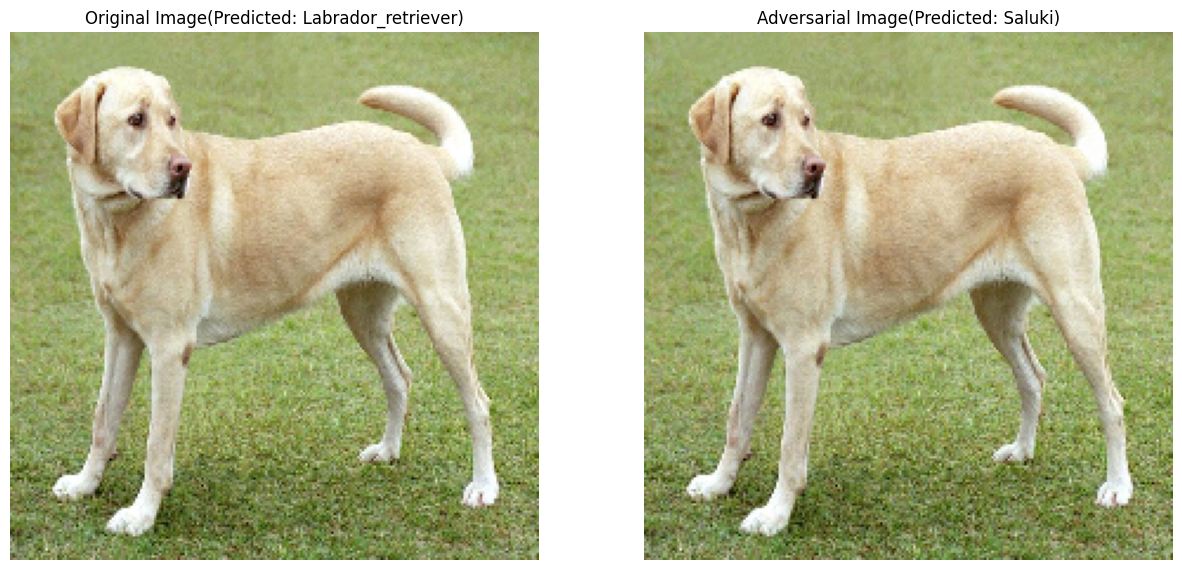

In [120]:
# Make sure x_original is a Tensor
x_original_tensor = tf.convert_to_tensor(x_original)

# FGSM attack
epsilon = 0.01
loss_object = CategoricalCrossentropy()

with tf.GradientTape() as tape:
    tape.watch(x_original_tensor)
    prediction = model(x_original_tensor)
    loss = loss_object(tf.one_hot([np.argmax(prediction)], 1000), prediction)

gradient = tape.gradient(loss, x_original_tensor)
signed_grad = tf.sign(gradient)
x_adversarial = x_original_tensor + epsilon * signed_grad
x_adversarial = tf.clip_by_value(x_adversarial, -1, 1)


# Predict adversarial
preds_adv = model(x_adversarial)
print("Adversarial prediction:", decode_predictions(preds_adv.numpy(), top=1)[0])

# Visualize adversarial image
plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(img_display)
plt.title(f"Original Image(Predicted: {decode_predictions(preds.numpy(), top=1)[0][0][1]})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow((x_adversarial[0].numpy() + 1) / 2)
plt.title(f"Adversarial Image(Predicted: {decode_predictions(preds_adv.numpy(), top=1)[0][0][1]})")
plt.axis("off")
plt.show()


### 4️⃣ Grad-CAM helper function


In [121]:
def compute_gradcam(model, img, class_idx, target_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(target_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    for i, w in enumerate(pooled_grads):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224, 224))

    return cam


### 5️⃣ Run Grad-CAM on original and adversarial images


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3034']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3034']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


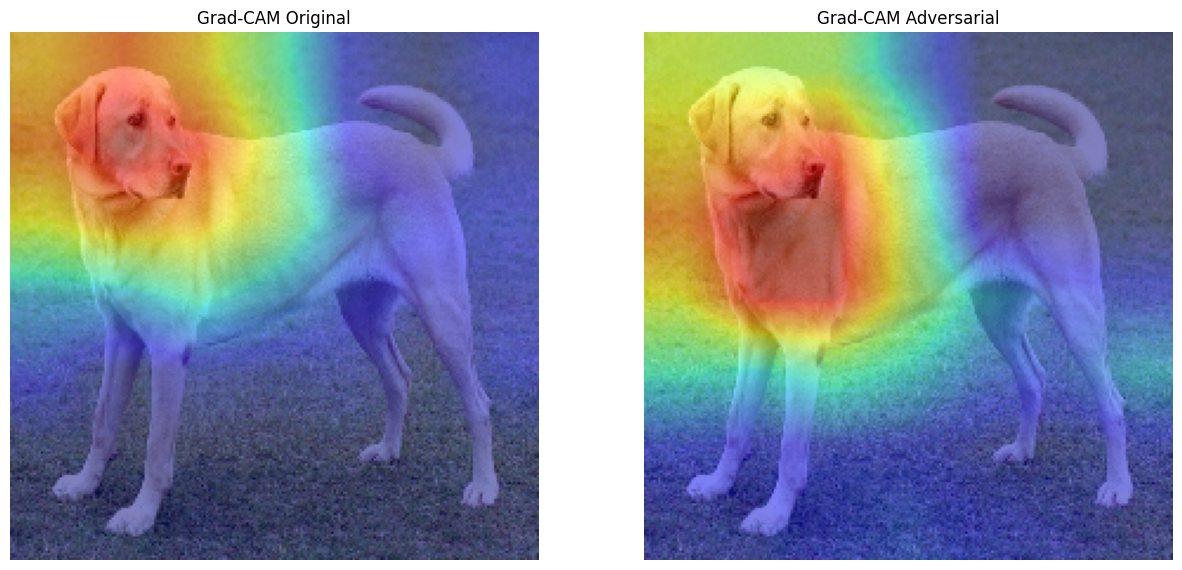

In [122]:
target_layer = 'Conv_1'  # Last conv layer in MobileNetV2

class_idx_orig = np.argmax(preds)
class_idx_adv = np.argmax(preds_adv)

cam_orig = compute_gradcam(model, x_original, class_idx_orig, target_layer)
cam_adv = compute_gradcam(model, x_adversarial, class_idx_adv, target_layer)

# Plot
plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(img_display)
plt.imshow(cam_orig, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Original")
plt.axis("off")


plt.subplot(1,2,2)
plt.imshow(img_display)
plt.imshow(cam_adv, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Adversarial")
plt.axis("off")
plt.show()



### 6️⃣ Integrated Gradients helper function


In [123]:
@tf.function
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

def compute_integrated_gradients(model, img, baseline=None, target_class_idx=None, m_steps=50, layer=None):
    if baseline is None:
        baseline = tf.zeros_like(img)
    alphas = tf.linspace(0.0, 1.0, m_steps)

    interpolated_images = interpolate_images(baseline, img, alphas)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        if layer:
            outputs = Model(model.inputs, model.get_layer(layer).output)(interpolated_images)
            predictions = model(interpolated_images)
        else:
            predictions = model(interpolated_images)
        loss = predictions[:, target_class_idx]

    grads = tape.gradient(loss, interpolated_images)
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (img - baseline)[0] * avg_grads
    return tf.reduce_sum(tf.math.abs(integrated_grads), axis=-1).numpy()


### 7️⃣ Run Integrated Gradients on original and adversarial images


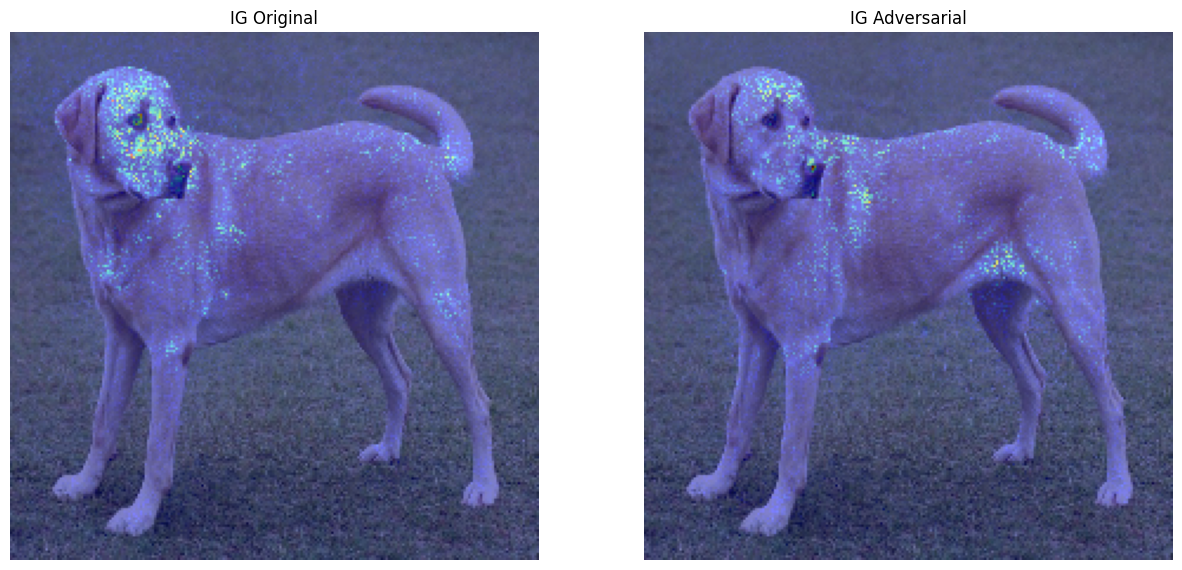

In [124]:
ig_orig = compute_integrated_gradients(model, x_original, target_class_idx=class_idx_orig)
ig_adv = compute_integrated_gradients(model, x_adversarial, target_class_idx=class_idx_adv)

# Plot
plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(img_display)
plt.imshow(ig_orig, cmap='jet', alpha=0.5)
plt.title("IG Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_display)
plt.imshow(ig_adv, cmap='jet', alpha=0.5)
plt.title("IG Adversarial")
plt.axis("off")
plt.show()


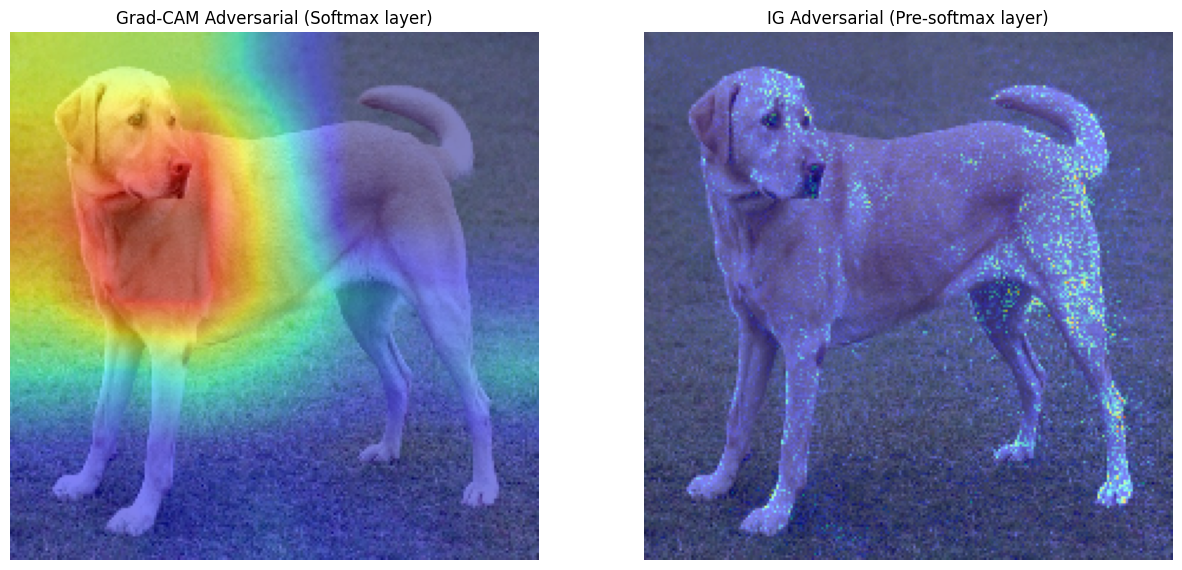

In [125]:
# Ensure x_adversarial is Tensor
x_adversarial = tf.convert_to_tensor(x_adversarial)  # if it's still a NumPy array

# Run Grad-CAM
cam_softmax = compute_gradcam(model, x_adversarial, class_idx_adv, target_layer_name='Conv_1')

# Run IG on logits
logits_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-1].input)
ig_pre_softmax = compute_integrated_gradients(logits_model, x_adversarial, target_class_idx=class_idx_adv)


plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(img_display)
plt.imshow(cam_softmax, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Adversarial (Softmax layer)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_display)
plt.imshow(ig_pre_softmax, cmap='jet', alpha=0.5)
plt.title("IG Adversarial (Pre-softmax layer)")
plt.axis("off")
plt.show()
